# Command Classification Using Recurrent Neural Nets (RNNs)

In this example, we will use PyTorch to classify sentences in the form of commands to a robot. For example:

```Find a red apple near the kitchen area```

Should return 3 output labels:
* Action: Find
* Room: Kitchen
* Object: Apple

This is therefore a 3-output multi-class classification problem. We will first encode our sentences using pretrained [GloVe word vectors](https://nlp.stanford.edu/projects/glove/) and then pass them through a Recurrent Neural Network (RNN) defined in [PyTorch](https://pytorch.org/).

This example based on work at MIT CSAIL by Sebastian Castro, 2020.

In [1]:
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

# Fix random seed for reproducibility
seed = 0
torch.manual_seed(0)
np.random.seed(0)

## Load Word Embeddings and Data

You will first need to download [GloVe vectors from the Stanford Web page](https://nlp.stanford.edu/projects/glove/). 

As you will see, there are various sizes of feature vectors that were trained on different sized corpora. For this example, we will download the "smallest" set of vectors which were trained on 6 billion tokens -- which are labeled as `glove.6B`.

1. Download the data from [this link](http://nlp.stanford.edu/data/glove.6B.zip)
2. Extract the downloaded ZIP file to the folder containing this notebook, so that you have a `glove.6B` folder at the same level as the notebook.

You will see that these are 4 different files in the folder -- tagged with the prefixes `50d`, `100d`, `200d`, and `300d`. These correspond to the embedding vector dimensions. The smaller vector sizes will take up much less memory when training and using a model, but will have less representational capacity. You should try different vector sizes below.

In [2]:
def load_embeddings(file_name, max_words=50000):
    """
    Read word vectors and create conversion dictionaries from a word embeddings file
    Optionally, you can change the number of maximum words to use
    """

    # Initialize the dictionaries with the unknown token
    word_to_ix = {"<UNK>": 0}
    ix_to_word = {0: "<UNK>"}
    vectors = [[]]

    # Go through all the words, get their embedding vectors, and add to the dictionaries
    with open(file_name,"r") as f:
        counter = 0
        for line in f.readlines():
            items = line.split()
            if counter < max_words:
                counter += 1
                word_to_ix[items[0]] = counter
                ix_to_word[counter] = items[0]
                vectors.append([float(x) for x in items[1:]])

        # Randomly set the weights of the first element mapping to "UNKNOWN"
        vector_len = len(vectors[-1])
        vectors[0] = [np.random.random() * 2.0 - 1.0
                        for _ in range(vector_len)]

    return np.array(vectors), word_to_ix, ix_to_word


def prepare_input_sequence(sentence, word_to_ix):
    """ Uses the word to index dictionary to create a sequence of vocabulary indices """
    
    # Convert sentence to lower case, remove punctuation, and split
    sentence = sentence.translate(str.maketrans("","", string.punctuation))
    seq = sentence.lower().split(" ")
    
    # Now convert to a word index
    indices = []
    for w in seq:
        try:
            idx = word_to_ix[w]
        except:
            idx = 0 # UNK token
        indices.append(idx)
    return indices


def prepare_target_sequence(seq, action_to_ix, room_to_ix, obj_to_ix):
    """
    Uses the output grounding target dictionaries to create a sequence of output indices
    """
    action_idxs = [action_to_ix[seq[0]]]
    room_idxs = [room_to_ix[seq[1]]]
    object_idxs = [obj_to_ix[seq[2]]]
    return action_idxs, room_idxs, object_idxs


glove_file = os.path.join("glove.6B", "glove.6B.100d.txt") # Modify this as needed
glove_vectors, w2i, i2w = load_embeddings(glove_file)

## Define a PyTorch Dataset

PyTorch offers various utilities for connecting your data to a neural network based training and/or inference pipeline. These are specifically 

* **Datasets** for managing the data and loading individual items
* **Dataloaders** for handling dataset-wide utilities like shuffling, batching, etc.
* **Transforms** for applying run-time transformations and/or data augmentation techniques to the data

Refer to [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for more information.

For simplicity, this example only uses a *dataset*, which means that it cannot be directly used to train and infer on batches of data. We will do all training and inference one text sequence at a time, which certainly slows things down but hopefully makes it easier to follow the example.

The data itself can be found in the `data` folder, namely in the [`rnn_training_data.txt`](data/rnn_training_data.txt) and [`rnn_test_data.txt`](data/rnn_test_data.txt). You can also randomly generate your own dataset using the [`generate_rnn_data.py`](data/generate_rnn_data.py) script.

In [3]:
class GroundingDataset(Dataset):
    """ Language grounding dataset """

    def __init__(self, filename, word_to_ix, action_to_ix, room_to_ix, object_to_ix, transform=None):
        self.data = pd.read_table(filename, sep=",")
        self.word_to_ix = word_to_ix
        self.action_to_ix = action_to_ix
        self.room_to_ix = room_to_ix
        self.object_to_ix = object_to_ix

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        item = self.data.iloc[idx].to_dict()
        inp_seq = item["Sentence"]
        inp = prepare_input_sequence(inp_seq, self.word_to_ix)
        tgt_seq = (item["Action"], item["Room"], item["Object"])
        tgt = prepare_target_sequence(tgt_seq,
            self.action_to_ix, self.room_to_ix, self.object_to_ix)

        return torch.LongTensor(inp), torch.LongTensor(tgt)

    def get_sentence(self, idx):
        return self.data["Sentence"][idx]

    def print_dataset(self):
        display(self.data) # If not in a Jupyter notebook, use print(self.data)
        print("")


def create_grounding_dict(grounding_list):
    """
    Creates a grounding dictionary from a list. For example:
        ["Find,"Go","Get","Store"]
    becomes
        {"Find":0, "Get":1, "Go":2, "Store":3}
    """

    idx = 0
    grounding_dict = {}
    for elem in grounding_list:
        grounding_dict[elem] = idx
        idx += 1

    return grounding_dict


def create_target_dictionaries(training_file):
    """
    Create dictionaries for all the outputs (targets) of the grounding network
    """

    # Read the training data and get sorted list of all the groundings
    data = pd.read_table(training_file,sep=",")
    action_list = sorted(set(data.Action))
    room_list = sorted(set(data.Room))
    object_list = sorted(set(data.Object))

    # Convert to dictionary that is compatible with the grounding model
    action_to_ix = create_grounding_dict(action_list)
    room_to_ix = create_grounding_dict(room_list)
    object_to_ix = create_grounding_dict(object_list)
    return action_to_ix, room_to_ix, object_to_ix

# Create the training and test datasets
training_file = os.path.join("data", "rnn_training_data.txt")
test_file = os.path.join("data", "rnn_test_data.txt")
act2i, room2i, obj2i = create_target_dictionaries(training_file)
training_data = GroundingDataset(training_file, w2i, act2i, room2i, obj2i)
test_data = GroundingDataset(test_file, w2i, act2i, room2i, obj2i)

# Print the training dataset, which internally stores data as a Pandas table
training_data.print_dataset()

# Get a random item from the training data and view its PyTorch-compatible representation
idx = np.random.randint(0, training_data.__len__())
print(training_data.get_sentence(idx))
item = training_data.__getitem__(idx)
print("\nWord indices:\n{}".format(item[0]))
print("\nTarget indices:\n{}".format(item[1]))

,Sentence,Action,Room,Object
0,move by the cookies by the parlor,go,living room,snack
1,fetch a chips inside the my room,get,bedroom,snack
2,clean up the apple from the living room,store,living room,fruit
3,locate some water from the bedroom,find,bedroom,drink
4,clean up an item from the pantry,store,kitchen,unknown
...,...,...,...,...
995,put back a thing in the canteen,store,kitchen,unknown
996,find me an item near the parlor,find,living room,unknown
997,go near the chips,go,unknown,snack
998,bring a beverage close to the pantry,get,kitchen,drink



get me some banana by the bedroom

Word indices:
tensor([  170,   286,    78, 10706,    22,     1,  7093])

Target indices:
tensor([[1],
        [0],
        [1]])


## Define Recurrent Neural Network (RNN) Architecture

Now that we covered the important supporting part of getting our data loaded as PyTorch Tensors, we finally get to the "fun" part which is defining the neural network architecture. The class below has several options for modifying the network sizes and structure. The important parameters are:

* `unit_type` - Can be `rnn` ("vanilla RNN" with `tanh` activation), `gru` (Gated Recurrent Unit), or `lstm` (Long-Short Term Memory)
* `bidir` - Set to `True` or `False` for bidirectionality
* `hidden_dim` - The hidden dimension of each recurrent unit
* `num_layers` - Number of total recurrent layers

As mentioned earlier, this will work only by passing individual inputs or batches of fixed-size sequences, as it makes the syntax simpler.

If you want to use batches of data with variable-size sequences, you may want to look at the [`pad_packed_sequence`](https://pytorch.org/docs/master/generated/torch.nn.utils.rnn.pad_packed_sequence.html) and [`pack_padded_sequence`](https://pytorch.org/docs/master/generated/torch.nn.utils.rnn.pack_padded_sequence.html) functions. You can also follow [this tutorial by suzyahyah](https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html).

In [4]:
class GroundingNetwork(nn.Module):
    """Neural network for language grounding"""

    def __init__(self, action_size, room_size, object_size,
                 unit_type="rnn", hidden_dim=32, num_layers=2, 
                 emb_weights=glove_vectors, bidir=False, dropout=0.25):

        super().__init__()

        # Set dimension of hidden layer depending on LSTM directionality
        if bidir:
            self.hidden_dim = hidden_dim * 2
        else:
            self.hidden_dim = hidden_dim

        # Initialize word embeddings from the pretrained vectors and freeze the weights
        self.word_embeddings = nn.Embedding.from_pretrained(torch.Tensor(emb_weights), freeze=True)
        (_, embedding_dim) = emb_weights.shape

        # The RNN layers take word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.unit_type = unit_type
        if self.unit_type == "rnn":
            self.recurrent = nn.RNN(embedding_dim, hidden_dim,
                                num_layers=num_layers, bidirectional=bidir,
                                nonlinearity="tanh", dropout=dropout, 
                                batch_first=True)
        elif self.unit_type == "gru":
            self.recurrent = nn.GRU(embedding_dim, hidden_dim,
                                num_layers=num_layers, bidirectional=bidir,
                                dropout=dropout, batch_first=True)
        elif self.unit_type == "lstm":
            self.recurrent = nn.LSTM(embedding_dim, hidden_dim,
                                num_layers=num_layers, bidirectional=bidir, 
                                dropout=dropout, batch_first=True)
        
        # The linear layers that map from hidden state space to grounding space
        self.hidden2action = nn.Linear(self.hidden_dim, action_size)
        self.hidden2room = nn.Linear(self.hidden_dim, room_size)
        self.hidden2object = nn.Linear(self.hidden_dim, object_size)


    def forward(self, inp):

        # Embed the sentence
        embeds = self.word_embeddings(inp)

        # Pass through the LSTM Module
        rnn_out, _ = self.recurrent(embeds)

        # Grab the final RNN output for each batch element
        rnn_final = rnn_out[:,-1,:]

        # Final Fully Connected Networks
        action_scores = func.softmax(self.hidden2action(rnn_final), dim=1)
        room_scores = func.softmax(self.hidden2room(rnn_final), dim=1)
        object_scores = func.softmax(self.hidden2object(rnn_final), dim=1)

        return action_scores, room_scores, object_scores


# Create a sample network
net = GroundingNetwork(action_size=len(act2i), room_size=len(room2i), object_size=len(obj2i), 
                       unit_type="rnn", bidir=False)
print(net)
print("")

# Convert a sentence to a Torch Tensor of the word index sequence
test_sentence = "Go to the kitchen and find an apple."
test_sequence = prepare_input_sequence(test_sentence, w2i)
test_tensor = torch.LongTensor(test_sequence)
print("Sentence: {}".format(test_sentence))
print("Word Sequence: {}".format(test_sequence))
print("")

# Run inference using the randomly initialized weights
# (Everything should have ~equal probability since the model is not trained)
with torch.no_grad():
    act_scores, room_scores, obj_scores = net(test_tensor.view(1,-1))
print("Action scores: {}".format(act_scores.numpy()))
print("Room scores: {}".format(room_scores.numpy()))
print("Object scores: {}".format(obj_scores.numpy()))

GroundingNetwork(
  (word_embeddings): Embedding(50001, 100)
  (recurrent): RNN(100, 32, num_layers=2, batch_first=True, dropout=0.25)
  (hidden2action): Linear(in_features=32, out_features=4, bias=True)
  (hidden2room): Linear(in_features=32, out_features=4, bias=True)
  (hidden2object): Linear(in_features=32, out_features=4, bias=True)
)

Sentence: Go to the kitchen and find an apple.
Word Sequence: [243, 5, 1, 4907, 6, 597, 30, 3293]

Action scores: [[0.27299276 0.21096526 0.2631889  0.25285307]]
Room scores: [[0.23197006 0.31811956 0.23808897 0.21182136]]
Object scores: [[0.29734012 0.1590196  0.20281453 0.34082583]]


## Train a Network

Finally we get to train the RNN. Again, note that this will work only by passing individual inputs or batches with fixed-size sequences, as it makes the syntax simpler.

If you want to use batches of data with variable-size sequences, you may want to look at how to configure a DataLoader to collate batches using the [`pad_sequence`](https://pytorch.org/docs/master/generated/torch.nn.utils.rnn.pad_sequence.html) function. I will again point you to [this tutorial by suzyahyah](https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html).

Epoch 1, Iteration 500, Average Loss -1.3309
Epoch 1, Iteration 1000, Average Loss -2.0482
Epoch 2, Iteration 1500, Average Loss -2.3074
Epoch 2, Iteration 2000, Average Loss -2.5510
Epoch 3, Iteration 2500, Average Loss -2.6508
Epoch 3, Iteration 3000, Average Loss -2.6507
Epoch 4, Iteration 3500, Average Loss -2.6617
Epoch 4, Iteration 4000, Average Loss -2.6799
Epoch 5, Iteration 4500, Average Loss -2.8141
Epoch 5, Iteration 5000, Average Loss -2.9611
Epoch 5, Iteration 5000, Average Loss -2.9611


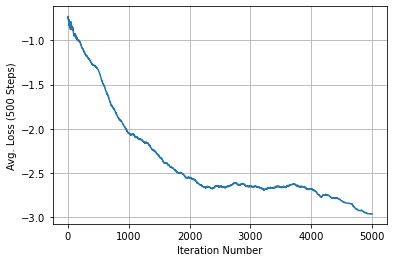

In [5]:
# Define a new RNN (so it's easier to change options without scrolling up)
# Try changing these options to see their effect
net = GroundingNetwork(action_size=len(act2i), room_size=len(room2i), object_size=len(obj2i),
                       hidden_dim=32, num_layers=2, unit_type="lstm", bidir=True, dropout=0.25)
                       
# Learning parameters
NUM_EPOCHS = 5      # Number of epochs
LEARN_RATE = 0.005  # Learning rate
ITER_WINDOW = 500   # Number of iterations to average loss for display
loss_function = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARN_RATE)
                             
# Training loop
i = 0
loss_window = deque(maxlen=ITER_WINDOW)
mean_losses = []
iter_ticks = []
for epoch in range(NUM_EPOCHS):
    for item in training_data:
        # Clear gradients
        net.zero_grad()

        # Run forward pass
        (inp, tgt) = item
        (action_scores, room_scores, object_scores) = net(inp.view(1,-1))
        action_targets = tgt[0]
        room_targets = tgt[1]
        object_targets = tgt[2]

        # Compute the loss, gradients, and update the parameters
        loss = loss_function(action_scores, action_targets) + \
               loss_function(room_scores, room_targets) + \
               loss_function(object_scores, object_targets)
        loss.backward()
        optimizer.step()

        # Add loss information for visualization at regular checkpoints
        i += 1
        loss_window.append(loss.detach().numpy())
        iter_ticks.append(i)
        mean_losses.append(np.mean(loss_window))
        if i % ITER_WINDOW == 0:
            print("Epoch {}, Iteration {}, Average Loss {:.4f}".format(epoch+1, i, mean_losses[-1]))

# Add loss information for the final iteration as well
loss_window.append(loss.detach().numpy())
iter_ticks.append(i)
mean_losses.append(np.mean(loss_window))
if i % ITER_WINDOW == 0:
    print("Epoch {}, Iteration {}, Average Loss {:.4f}".format(epoch+1, i, mean_losses[-1]))

# Plot the training results
plt.plot(iter_ticks, mean_losses)
plt.xlabel("Iteration Number")
plt.ylabel("Avg. Loss ({} Steps)".format(ITER_WINDOW))
plt.grid("on")
plt.show()

## Evaluate the Trained Network on the Test Set

Now we will use our trained network to run inference on the training and test sets. To do this, we have created a utility function.

Then, we can use these predictions to evaluate our model's accuracy.

In [7]:
def validate(net, data, word_to_ix, ix_to_word, action_to_ix, room_to_ix, object_to_ix, do_print=False):
    """ Runs inference on every element of `data` and returns the predictions """ 
    num_correct = 0
    idx = 0

    with torch.no_grad():
        for item in data:

            # Evaluate the model
            (inp, tgt) = item
            inp = inp.view(1,-1)
            (action_scores, room_scores, object_scores) = net(inp)

            # Find the max scores and predicted output
            tgt_list = tgt.tolist()                

            for i in range(action_scores.size()[0]):

                # Get predictions and indices
                _,act_ind = action_scores[i].max(0)
                _,room_ind = room_scores[i].max(0)
                _,obj_ind = object_scores[i].max(0)
                predicted_inds = (act_ind.item(),room_ind.item(),obj_ind.item())
                predicted_output = [list(action_to_ix)[predicted_inds[0]],
                                    list(room_to_ix)[predicted_inds[1]], 
                                    list(object_to_ix)[predicted_inds[2]]]
                
                # Get true grounding indices
                true_inds = (tgt_list[0][i],
                             tgt_list[1][i],
                             tgt_list[2][i])
                
                # Tally up the total number of correct predictions
                if predicted_inds == true_inds:
                    num_correct += 1

                # Print the output
                if do_print:
                    print("")
                    sentence = []
                    sentence_length = inp.shape[1]
                    for j in range(sentence_length):
                        elem = inp[i,j].item()
                        sentence.append(ix_to_word[elem])
                    print("Command: {}".format(" ".join(sentence)))
                    action_list = ["%.3f"%item for item in action_scores[i].tolist()]
                    print("Action scores: {}".format(action_list))
                    room_list = ["%.3f"%item for item in room_scores[i].tolist()]
                    print("Room scores: {}".format(room_list))
                    object_list = ["%.3f"%item for item in object_scores[i].tolist()]
                    print("Object scores: {}".format(object_list))
                    print("Prediction: {}".format(predicted_output))

                idx += 1

    return predicted_output, num_correct


# Calculate training and test accuracy
predicted_train, num_correct_train = validate(net, training_data, w2i, i2w, act2i, room2i, obj2i)
predicted_test, num_correct_test = validate(net, test_data, w2i, i2w, act2i, room2i, obj2i)
train_acc = 100*num_correct_train/len(training_data)
print("Training Accuracy = {}/{} ({:.2f}%)".format(num_correct_train, len(training_data), train_acc))
test_acc = 100*num_correct_test/len(test_data)
print("Test Accuracy = {}/{} ({:.2f}%)".format(num_correct_test, len(test_data), test_acc))

# Print on a few examples
num_samples = 5
sample_indices = np.random.choice(len(test_data), num_samples)
sample_data = [test_data.__getitem__(i) for i in sample_indices]
(sample_pred, sample_correct) = validate(net, sample_data, w2i, i2w, act2i, room2i, obj2i, do_print=True)

Training Accuracy = 972/1000 (97.20%)
Test Accuracy = 484/500 (96.80%)

Command: throw away the water near the kitchen
Action scores: ['0.000', '0.000', '0.000', '1.000']
Room scores: ['0.000', '1.000', '0.000', '0.000']
Object scores: ['1.000', '0.000', '0.000', '0.000']
Prediction: ['store', 'kitchen', 'drink']

Command: pick up some banana inside the bedroom
Action scores: ['0.000', '1.000', '0.000', '0.000']
Room scores: ['1.000', '0.000', '0.000', '0.000']
Object scores: ['0.000', '1.000', '0.000', '0.000']
Prediction: ['get', 'bedroom', 'fruit']

Command: find the cookies by the bedroom
Action scores: ['1.000', '0.000', '0.000', '0.000']
Room scores: ['1.000', '0.000', '0.000', '0.000']
Object scores: ['0.000', '0.000', '1.000', '0.000']
Prediction: ['find', 'bedroom', 'snack']

Command: bring the apple from the canteen
Action scores: ['0.000', '1.000', '0.000', '0.000']
Room scores: ['0.000', '1.000', '0.000', '0.000']
Object scores: ['0.000', '1.000', '0.000', '0.000']
Predicti